<a href="https://colab.research.google.com/github/SarveshD7/GANs-Fashion-Outfit-Generator/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Installing all the dependencies***

In [51]:
! pip install tensorflow tensorflow-gpu matplotlib tensorflow-datasets ipywidgets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... done
  Using cached jedi-0.18.2-py2.py3-none-any.whl (1.6 MB)
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tensorflow-gpu
  Running setup.py clean for tensorflow-gpu
Failed to build tensorflow-gpu
  error: subprocess-exited-with-error
  
  × Running setup.py install for tensorflow-gpu did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Running setup.py install for tensorflow-gpu ... error
error: legacy-install-failure

× Encountered error while trying to install package.
╰

***Importing tensorflow and limiting the virtual RAM growth***


In [52]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)
  

***Importing other dependencies***

In [53]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

***Getting the dataset***


In [54]:
ds = tfds.load('fashion_mnist', split='train')


***Visualizing the data***

In [55]:
import numpy as np # For some data transform

In [56]:
# Setup connection aka iterator
dataIterator = ds.as_numpy_iterator()

In [57]:
# Getting data out of pipeline
dataIterator.next()

{'image': array([[[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 18],
         [ 77],
         [227],
         [227],
         [208],
         [210],
         [225],
         [216],
         [ 85],
         [ 32],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 61],
         [100],
         [ 97],
         [ 80],
         [ 57],
         [117],
         [227],
         [238],
         [115],
         [ 49],
         [ 78],
         [106],
         [108],
         [ 71],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         

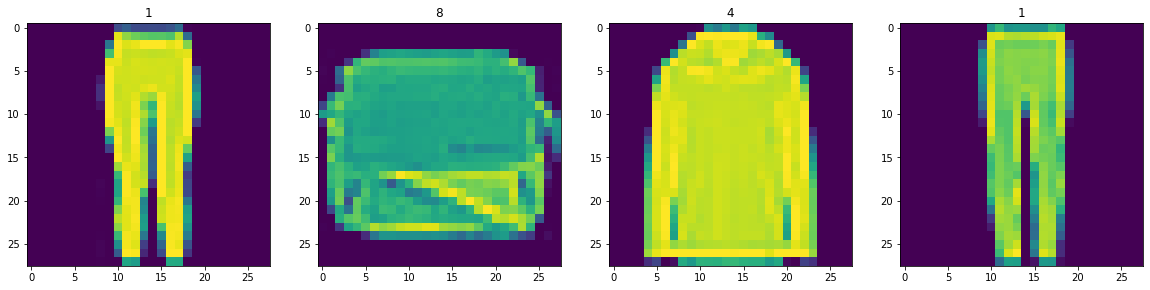

In [58]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx in range(4):
  # Grabbing the image and label
  batch = dataIterator.next()
  # Plot the image using a specific subplot
  ax[idx].imshow(np.squeeze(batch['image']))
  # Appending the image label as plot title
  ax[idx].title.set_text(batch['label'])

***Some data preprocessing***

In [59]:
# Scaling and returning the images only
def scale_images(data):
  image = data['image']
  return image / 255
  

In [60]:
ds = tfds.load('fashion_mnist', split='train')
# Running the images through the scale_images preprocessing step
ds = ds.map(scale_images)
# caching the dataset for that batch
ds = ds.cache()
# Shuffling the dataset
ds = ds.shuffle(60000)
# Batch into 128 images per sample
ds = ds.batch(128)
# Prefetching reduces the likelihood of bottlenecking
ds = ds.prefetch(64)




In [61]:
ds.as_numpy_iterator().next().shape # 128 images of size 28, 28, 1

(128, 28, 28, 1)

***Building the Neural Network***

In [62]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

Building the Generator

In [63]:
def build_generator():
  model = Sequential()

  # Takes in random values and reshapes it to 7x7x128
  # Beginnings ofa generated image  
  model.add(Dense(7*7*128, input_dim = 128))
  model.add(LeakyReLU(0.2))
  model.add(Reshape((7, 7, 128)))

  # Upsampling block 1
  model.add(UpSampling2D())
  model.add(Conv2D(128, 5, padding='same'))
  model.add(LeakyReLU(0.2))

  # Upsampling block 2
  model.add(UpSampling2D())
  model.add(Conv2D(128, 5, padding='same'))
  model.add(LeakyReLU(0.2))

  # Convolutional block 1
  model.add(Conv2D(128, 4, padding='same'))
  model.add(LeakyReLU(0.2))

   # Convolutional block 2
  model.add(Conv2D(128, 4, padding='same'))
  model.add(LeakyReLU(0.2))

  # Final Conv layer to get to one channel
  model.add(Conv2D(1,4,padding='same', activation='sigmoid'))


  return model


In [64]:
generator = build_generator()

In [65]:
generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 6272)              809088    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 6272)              0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_2 (UpSampling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                      

In [66]:
img  = generator.predict(np.random.randn(4, 128, 1))
# randn generates a set of random nos with normal distribution
img.shape


1/1 [==============================] - 0s 132ms/step


(4, 28, 28, 1)

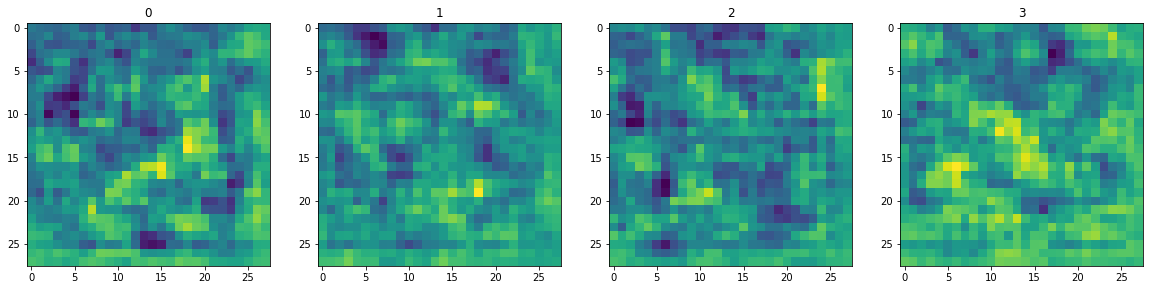

In [67]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img  in enumerate(img):
  ax[idx].imshow(np.squeeze(img))
  ax[idx].title.set_text(idx)

***Build Discriminator***

In [68]:
def build_discriminator():
  model = Sequential()

  # First Conv Block
  model.add(Conv2D(32, 5, input_shape=(28, 28, 1)))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

   # Second Conv Block
  model.add(Conv2D(64, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

 # Third Conv Block
  model.add(Conv2D(128, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

 # Fourth Conv Block
  model.add(Conv2D(256, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

 # Fourth Conv Block
  model.add(Conv2D(256, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # Flatten and then pass through Dense Layer
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))
  
  return model


In [69]:
discriminator = build_discriminator()

In [70]:
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 24, 24, 32)        0         
                                                                 
 dropout_6 (Dropout)         (None, 24, 24, 32)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_7 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_17 (Conv2D)          (None, 16, 16, 128)      

In [71]:
img.shape

(28, 28, 1)

In [72]:
discriminator.predict(np.expand_dims(img,0))

1/1 [==============================] - 0s 97ms/step


array([[0.5047907]], dtype=float32)

***Constructing Training Loops***

***Setting up Losses and Optimizers***

In [73]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy


In [74]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

In [75]:
from tensorflow.keras.models import Model


In [82]:
class FashionGAN(Model):
  # passing the generator, discriminator, any positional or keyboard arguments
  def __init__(self, generator, discriminator, *args, **kwargs):
    super().__init__(*args, **kwargs)

    self.generator = generator
    self.discriminator = discriminator
    pass

  def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
    super().compile(*args, **kwargs)

    self.g_opt = g_opt
    self.d_opt = d_opt
    self.g_loss = g_loss
    self.d_loss = d_loss
    pass 

  def train_step(self, batch):
    # Getting the data
    real_images = batch
    fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)

    # Training the discriminator
    with tf.GradientTape() as d_tape:
        # To start calculating the gradients
      # -- Pass the real and fake images to the discriminator model
      yhat_real = self.discriminator(real_images, training=True)
      # Training = True makes the dropout layers run else they won't run
      yhat_fake = self.discriminator(fake_images, training=True)
      yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

    # -- Create labels for real and fake images
      y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
    # -- Add sonme noise to the outputs
      noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
      noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
      y_realfake += tf.concat([noise_real, noise_fake], axis=0)

    # -- Calculate loss BINARY CROSSENTROPY 
      total_d_loss = self.d_loss(y_realfake, yhat_realfake)

    # -- Apply backpropagation 
    dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
    self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

    # Train the generator
    with tf.GradientTape() as g_tape:
      # Generate some new images
      gen_images = self.generator(tf.random.normal((128, 128, 1)), training=True)

      # Create the predicted labels
      predicted_labels = self.discriminator(gen_images, training = False)

      # Calculate loss
      total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)
      # The true value is all zeros ie, we say that the generated image is real

      # Apply backpropagation
      ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
      self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

      return {"d_loss":total_d_loss, "g_loss":total_g_loss}

    pass
  def test_step(self):
    pass



In [83]:
# Creating instance of our fashgan class
fashgan = FashionGAN(generator, discriminator)


In [84]:
# Compile the fashgan model
fashgan.compile(g_opt, d_opt, g_loss, d_loss)
              

***Building a call back***

In [85]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [88]:
# To save the generated image in each step
# class ModelMonitor(Callback):
#   def __init__(self, num_img=3, latent_dim = 128):
#     self.num_img = num_img
#     self.latent_dim = latent_dim

#   def on_epoch_end(self, epoch, logs=None):
#     random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
#     generated_images = self.model.generator(random_latent_vectors)
#     generated_images *= 255
#     generated_images.numpy()
#     for i in range(self.num_img):
#       img = array_to_img(generated_images[i])
#       img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))



***Training the model***

In [89]:
hist = fashgan.fit(ds, epochs=20)
# For better performance actually visible results--->epochs>=2000

Epoch 1/20
469/469 [==============================] - 93s 198ms/step - d_loss: 0.3202 - g_loss: 8.3456
Epoch 2/20
469/469 [==============================] - 93s 198ms/step - d_loss: 0.2839 - g_loss: 9.8317
Epoch 3/20
469/469 [==============================] - 93s 198ms/step - d_loss: 0.2779 - g_loss: 8.7294
Epoch 4/20
469/469 [==============================] - 93s 198ms/step - d_loss: 0.2857 - g_loss: 6.5645
Epoch 5/20
469/469 [==============================] - 93s 199ms/step - d_loss: 0.5187 - g_loss: 1.3831
Epoch 6/20
469/469 [==============================] - 93s 198ms/step - d_loss: 0.2743 - g_loss: 2.6618
Epoch 7/20
469/469 [==============================] - 93s 198ms/step - d_loss: 0.2720 - g_loss: 2.7104
Epoch 8/20
469/469 [==============================] - 93s 199ms/step - d_loss: 0.2711 - g_loss: 2.7372
Epoch 9/20
469/469 [==============================] - 93s 199ms/step - d_loss: 0.2702 - g_loss: 2.7558
Epoch 10/20
469/469 [==============================] - 93s 198ms/step - d

In [90]:
hist.history

{'d_loss': [0.29353585839271545,
  0.2843027710914612,
  0.2814917266368866,
  0.27330976724624634,
  0.2731948792934418,
  0.26904550194740295,
  0.27256569266319275,
  0.27469465136528015,
  0.25458425283432007,
  0.2669667601585388,
  0.28062453866004944,
  0.2695857286453247,
  0.26630347967147827,
  0.2664530873298645,
  0.263400673866272,
  0.2655476927757263,
  0.2695879340171814,
  0.27214011549949646,
  0.2499813735485077,
  0.26146596670150757],
 'g_loss': [10.201425552368164,
  9.277681350708008,
  8.217305183410645,
  2.6802046298980713,
  2.5935866832733154,
  2.740337371826172,
  2.7480969429016113,
  2.711757183074951,
  2.7270493507385254,
  2.766094923019409,
  2.760432243347168,
  2.7654848098754883,
  2.9234328269958496,
  2.82078218460083,
  2.764085292816162,
  2.787130355834961,
  2.7681779861450195,
  2.7433829307556152,
  2.7865538597106934,
  2.7553625106811523]}

***Reviewing the Performance***

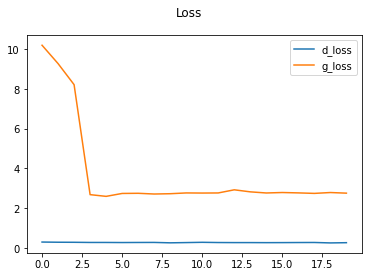

In [92]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

***Testing the Generator***

In [93]:
# Generating images
imgs = generator.predict(tf.random.normal((16, 128, 1)))


1/1 [==============================] - 0s 186ms/step


In [ ]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(20, 20))
for r in range(4):
  for c in range(4):
    ax[r][c].imshow(imgs[(r+1)*(c+1)-1])
    